In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import matplotlib.colors as mcolors


import os
from numba import njit
import sys 
module_path = "src"
sys.path.append(module_path)
import polyomino_gcmc_simulation




In [31]:
omino_1 = np.array([[0,0],[0,-1],[0,1],[-1,0],[1,0]],dtype=np.int32)
omino_2 = np.array([[0,-2],[0,-1],[0,0],[0,1],[0,2]],dtype=np.int32)


omino_1 = omino_1[..., np.newaxis]  
omino_2 = omino_2[..., np.newaxis] 

ominos_sizes= np.array([5,5],dtype=np.int32)
max_omino_size=np.max(ominos_sizes)

omino_shapes = np.concatenate([omino_1, omino_2], axis=2)
n_omino_types = omino_shapes.shape[-1]


In [32]:
box_size = 100
initial_n_ominos_per_shape=np.array([40,40],dtype=np.int32)
initial_n_ominos = np.sum(initial_n_ominos_per_shape)

crystal_cell_size_x = 3
crystal_cell_size_y = max_omino_size
crystal_n_cells = (box_size//crystal_cell_size_x)*(box_size//crystal_cell_size_y)

if crystal_n_cells < initial_n_ominos:
    raise ValueError('INCREASE box_size')


crystal_coords=[]
for ix in range(box_size//crystal_cell_size_x):
    for iy in range(box_size//crystal_cell_size_y):
        crystal_coords.append([ix*crystal_cell_size_x+1,iy*crystal_cell_size_y+1])
crystal_coords=np.array(crystal_coords,dtype=np.int32)

crystal_coords_order=np.arange(crystal_n_cells,dtype=np.int32)
np.random.shuffle(crystal_coords_order)
crystal_coords_order=crystal_coords_order[:initial_n_ominos]

initial_positions=crystal_coords[crystal_coords_order]
initial_orientations = np.ones(initial_n_ominos,dtype=np.int32)


In [33]:
# First part: Create vec_omino_types array
i_omino = 0
vec_omino_types = np.zeros(initial_n_ominos, dtype=int)

for i_omino_type in range(1, n_omino_types + 1):  # 1 to n_omino_types (inclusive)
    for i_omino_of_type in range(initial_n_ominos_per_shape[i_omino_type - 1]):  # Convert to 0-based indexing
        vec_omino_types[i_omino] = i_omino_type
        i_omino += 1

# Second part: Create rotated shapes array
rot_omino_shapes = np.zeros((max_omino_size, 2, n_omino_types, 4), dtype=int)

for i_omino_type in range(1, n_omino_types + 1):  # 1 to n_omino_types (inclusive)
    omino_type_idx = i_omino_type - 1  # Convert to 0-based for array indexing
    
    for i_cell in range(ominos_sizes[omino_type_idx]):  # 0 to ominos_sizes-1
        # Get original coordinates (convert from 1-based to 0-based indexing)
        orig_x = omino_shapes[i_cell, 0, omino_type_idx]
        orig_y = omino_shapes[i_cell, 1, omino_type_idx]
        
        # Rotation 1: 0 degrees clockwise (x,y) -> (x,y)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 0] = orig_x
        rot_omino_shapes[i_cell, 1, omino_type_idx, 0] = orig_y
        
        # Rotation 2: 90 degrees clockwise (x,y) -> (-y,x)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 1] = -orig_y
        rot_omino_shapes[i_cell, 1, omino_type_idx, 1] = orig_x
        
        # Rotation 3: 180 degrees (x,y) -> (-x,-y)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 2] = -orig_x
        rot_omino_shapes[i_cell, 1, omino_type_idx, 2] = -orig_y
        
        # Rotation 4: 270 degrees clockwise (x,y) -> (y,-x)
        rot_omino_shapes[i_cell, 0, omino_type_idx, 3] = orig_y
        rot_omino_shapes[i_cell, 1, omino_type_idx, 3] = -orig_x


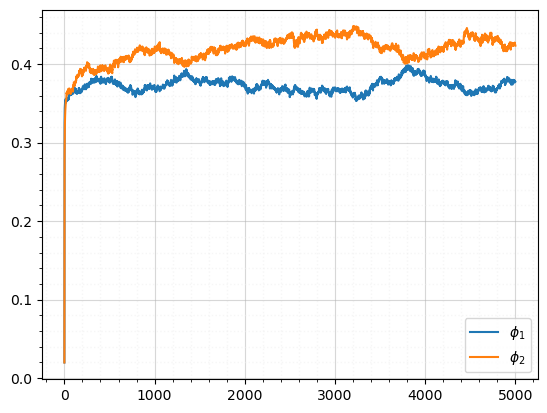

In [ ]:
n_savings=5000

n_mc_steps=80000*n_savings

save_every=n_mc_steps//n_savings
prng_seed=np.random.randint(1,100000)

max_n_ominos=10000
move_probabilities=np.array([0.0,0.0,0.5,0.5])

chemical_potentials=np.array([20.0,20.0])
chemical_potentials=13*np.array([1.0,1.0])

system_snapshots,history_positions,history_orientations,history_n_ominos,\
        history_n_ominos_per_shape,history_vec_omino_types = polyomino_gcmc_simulation.polyomino_gcmc_simulation(
        n_mc_steps=n_mc_steps,
        n_savings=n_savings,
        n_omino_types=n_omino_types,
        ominos_sizes=ominos_sizes,
        max_omino_size=max_omino_size,
        omino_shapes=omino_shapes,
        initial_n_ominos_per_shape=initial_n_ominos_per_shape, 
        initial_n_ominos=initial_n_ominos,
        initial_positions=initial_positions,
        initial_orientations=initial_orientations,
        max_n_ominos=max_n_ominos,
        chemical_potentials=chemical_potentials,
        move_probabilities=move_probabilities,
        box_size=box_size,
        prng_seed=prng_seed
    )
fig,ax=plt.subplots()
ax.grid(alpha=0.5, which='both')
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=1)
ax.minorticks_on()
ax.set_axisbelow(True)

for i_omino_type in range(n_omino_types):
    ax.plot(ominos_sizes[i_omino_type]*history_n_ominos_per_shape[i_omino_type,:]/box_size**2,
            label=f"$\phi_{i_omino_type+1:}$")
ax.legend()

In [37]:
import polyomino_simulation


In [36]:
(history_n_ominos_per_shape[0,:]==history_n_ominos_per_shape[1,:]).sum()

2

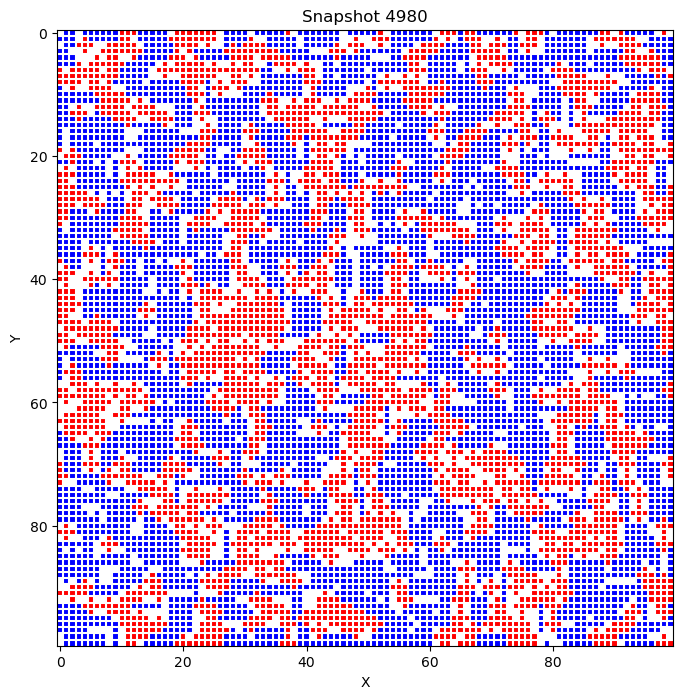

In [ ]:
colors = ['white', 'red', 'blue']
cmap = mcolors.ListedColormap(colors)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Your snapshot indices (same as before)
i_snapshot_to_plot = np.arange(0, n_savings, 20)

# Create figure and axis once (outside the loop)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size as needed
ax.set_aspect('equal')
ax.set_axisbelow(True)
ax.set_title('System Evolution')  # Optional: add a title
ax.set_xlabel('X')
ax.set_ylabel('Y')

# Initial plot (for frame 0)
im = ax.imshow(system_snapshots[:,:,i_snapshot_to_plot[0]], cmap=cmap, vmin=0, vmax=n_omino_types)
for ii in range(0,box_size-1):
    ax.axhline(ii+0.5,c='w')
    ax.axvline(ii+0.5,c='w')
# plt.colorbar(im, ax=ax)  # Optional: add colorbar

# Update function for animation
def update(frame):
    # Clear previous image and plot new one
    im.set_array(system_snapshots[:,:,i_snapshot_to_plot[frame]])
    ax.set_title(f'Snapshot {i_snapshot_to_plot[frame]}')  # Optional: dynamic title
    return [im]

# Create the animation
anim = FuncAnimation(fig, update, frames=len(i_snapshot_to_plot), 
                     interval=200, blit=True, repeat=True)  # interval=200ms between frames

# Save as GIF (requires Pillow: pip install pillow)
anim.save('gifs/test_gcmc_system_evolution_5.gif', writer=PillowWriter(fps=5))  # fps=5 for ~200ms intervals

# Optional: Show the animation in a window (uncomment to preview)
# plt.show()



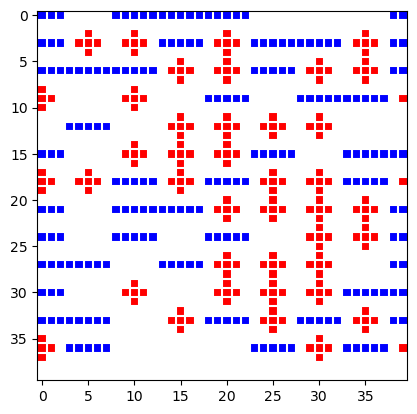

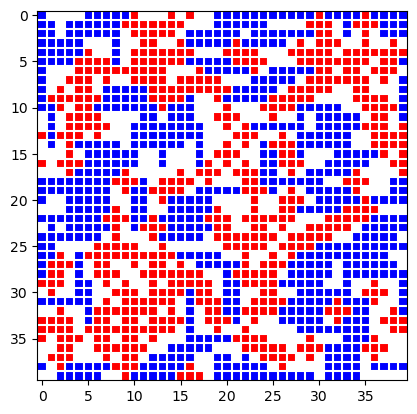

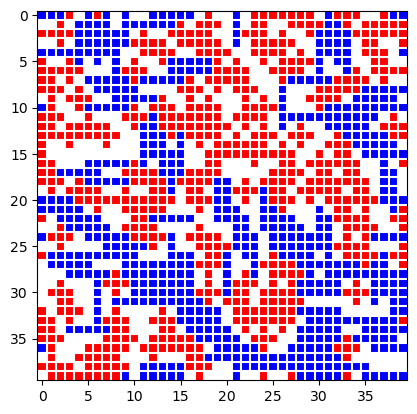

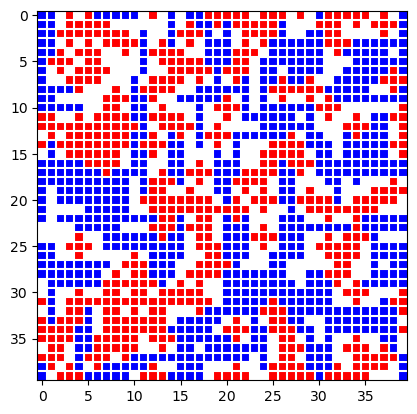

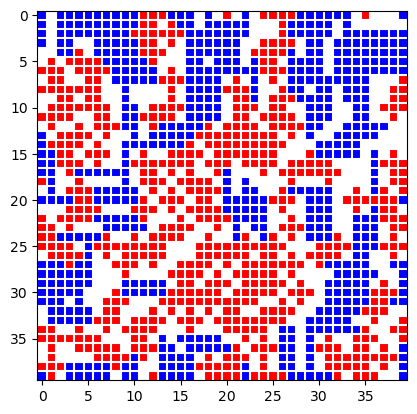

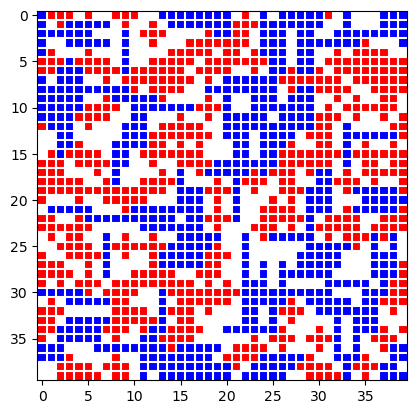

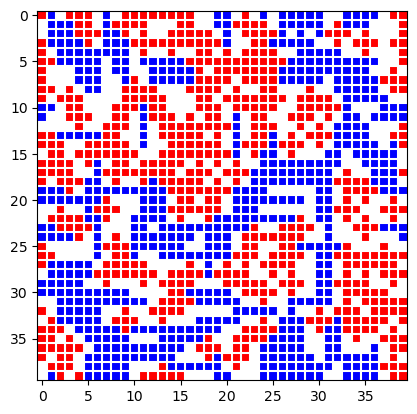

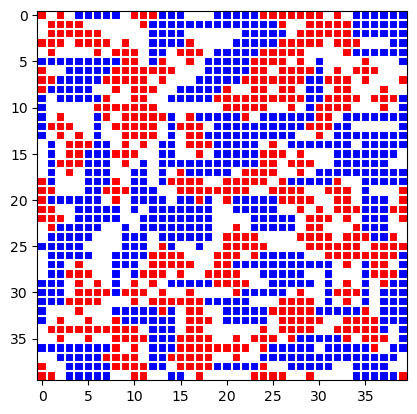

In [ ]:

colors = ['white', 'red', 'blue']
cmap = mcolors.ListedColormap(colors)

i_snapshot_to_plot=np.arange(0,n_savings,1000)
for i_snapshot in i_snapshot_to_plot:
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axisbelow(True)
    ax.imshow(system_snapshots[:,:,i_snapshot], cmap=cmap, vmin=0, vmax=n_omino_types)

    for ii in range(0,box_size-1):
        ax.axhline(ii+0.5,c='w')
        ax.axvline(ii+0.5,c='w')